# Lithium Oven Optic 7

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
import numpy.ma as ma
from copy import copy
import matplotlib.colors as colors
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_7/'
lam = 0.796
tau = 70
# All length units are in um

Optic 7 is an iteration of optic 6 taking into account the corrected index of lithium vapor and using an updated ionization model based on TDSE calculations, rather than the adk used for optic 6.. This notebook contains the detailed designs for the optics as well as simulations of the beam dump.

In [2]:
plasma_LO, I, z, sim_start, sim_length, pulse = design.load_plasma_design(path)

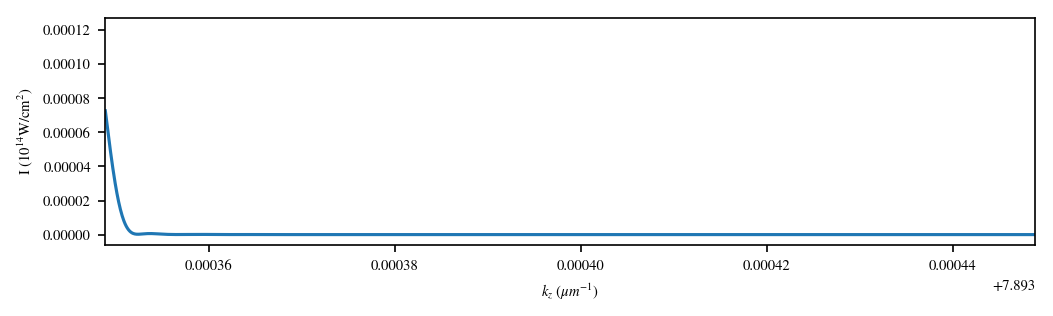

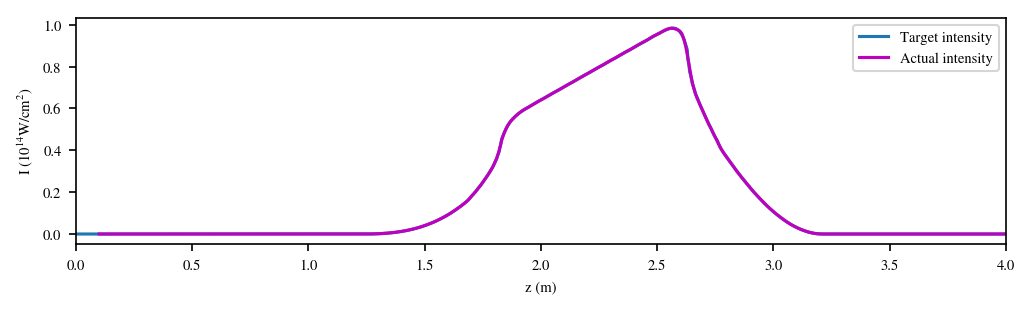

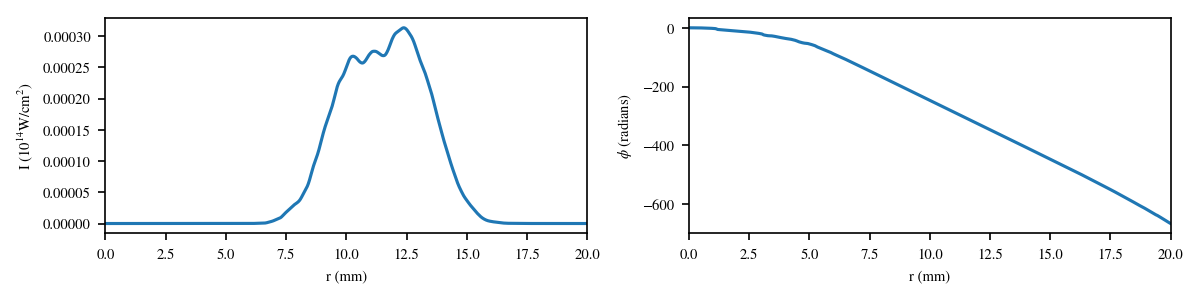

In [3]:
# Optic design upstream
width = 60
xlim = [0, 4]
z0 = 1.83075e6
z_optic, I_optic = design.extend_zI(z0, 'start', z, I, sim_start, sim_length)
I_optic *= 1
r, E = design.calculate_tran_field(z_optic, I_optic, 20e3, width, lam, path, 10e-5, xlim, [0, 20])

In [4]:
L = 0.8e6
R_max = 15e3
X = 80e3
Nx = 2**13
ri = np.linspace(0, R_max, len(r))
Ei = np.ones(len(r))
rA, phiA, lensA, multi = design.create_lens_A(ri, Ei, r, E, L, path, lam, X, Nx)

Maximum phase gradient 0.0664 rad/um


Total input energy 15.55mJ


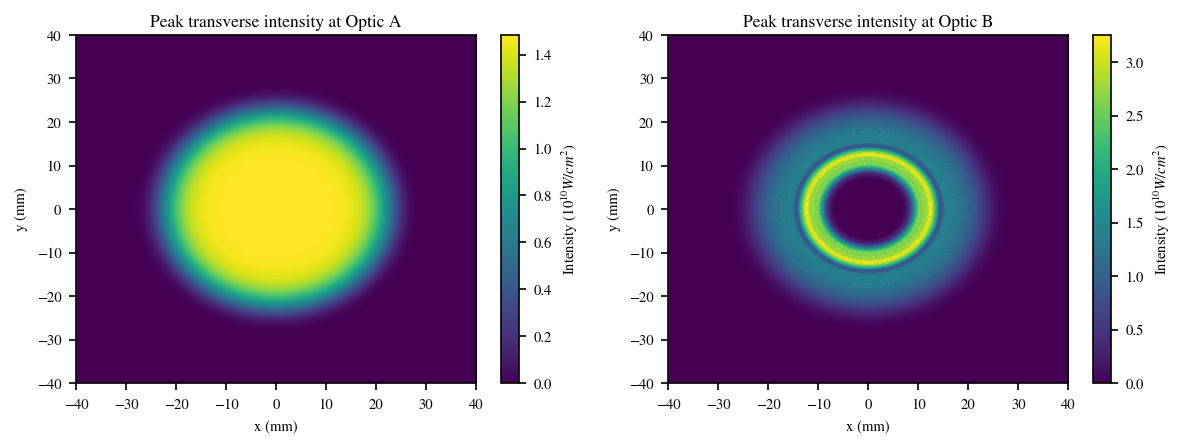

In [5]:
n = 8
w0 = 25e3
r0 = np.linspace(0, 100e3, 5000)
E0 = np.exp(-(r0/w0)**n)*multi
#sel = r0 > 15e3 # Stop the outer rings from propagating
#E0[sel] = 0.0
beam0 = design.propagate_to_lens_B(r0, E0, L, path, lam, lensA, tau, 20)

Maximum phase gradient 0.34 rad/um


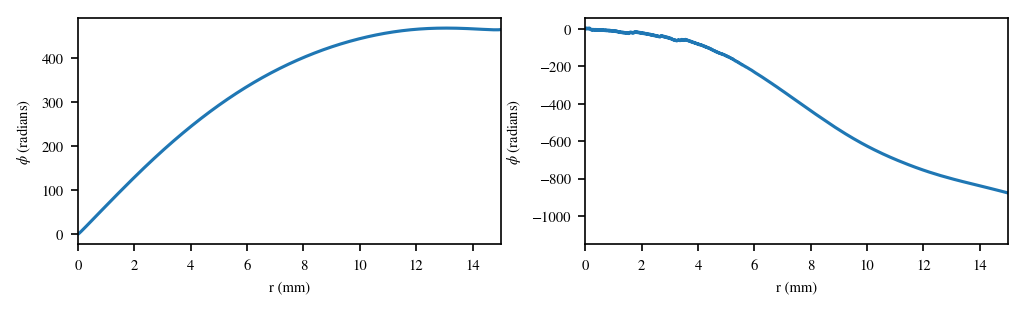

In [12]:
Nx = 2**12
X = 40e3
rB, phiB, lensB = design.create_lens_B(beam0, r, E, path, lam, X, Nx)
design.plot_phase(rA, phiA, rB, phiB, [0, 15])

In [31]:
def max_phase_gradient(r, phi):
    dr = r[1:] - r[:-1]
    dphi = phi[1:] - phi[:-1]
    gradphi = dphi/dr
    plt.plot(r[1:], gradphi)
    plt.show()
    return np.amax(abs(gradphi))

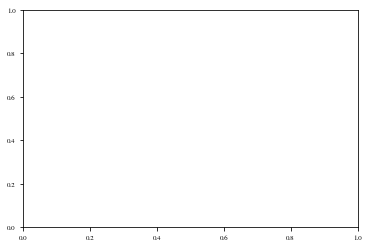

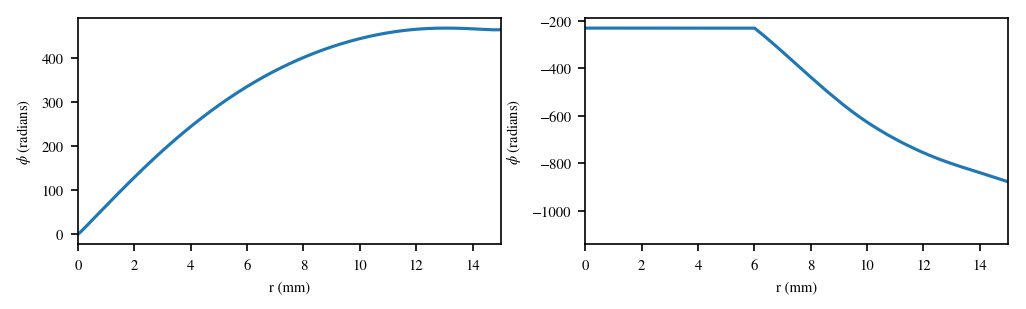

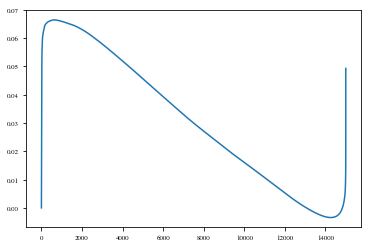

Maximum phase gradient for A of 0.0664 rad/um


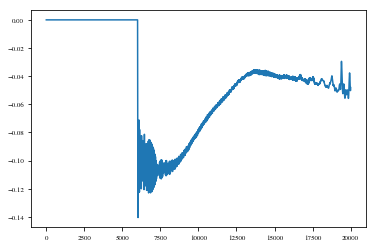

Maximum phase gradient for B of 0.1406 rad/um


In [32]:
sel = rA < 15e3
np.save(path+'lensA_Phase.npy', [rA[sel], phiA[sel]])
sel = rB < 6e3
phiB[sel] = phiB[np.logical_not(sel)][0]
sel = rB < 15e3
np.save(path+'lensB_Phase.npy', [rB[sel], phiB[sel]])
design.plot_phase(rA, phiA, rB, phiB, [0, 15])
dphi = max_phase_gradient(rA, phiA)
print('Maximum phase gradient for A of %0.4f rad/um' % dphi)
dphi = max_phase_gradient(rB, phiB)
print('Maximum phase gradient for B of %0.4f rad/um' % dphi)

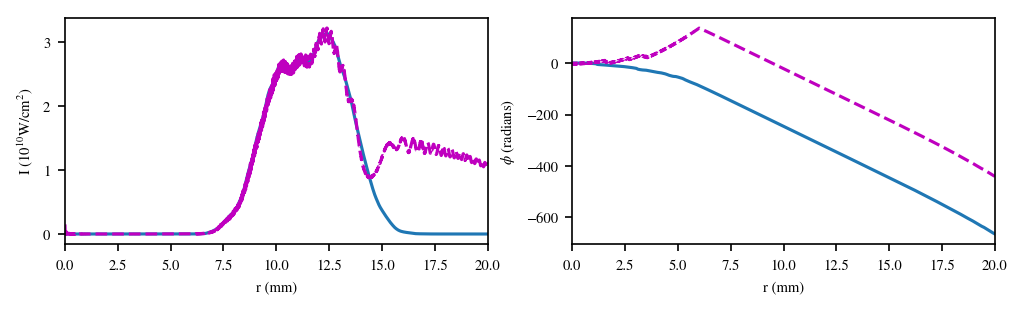

In [8]:
r1, e1 = design.field_after_lens_B(beam0, rB, phiB, r, E, [0, 20])

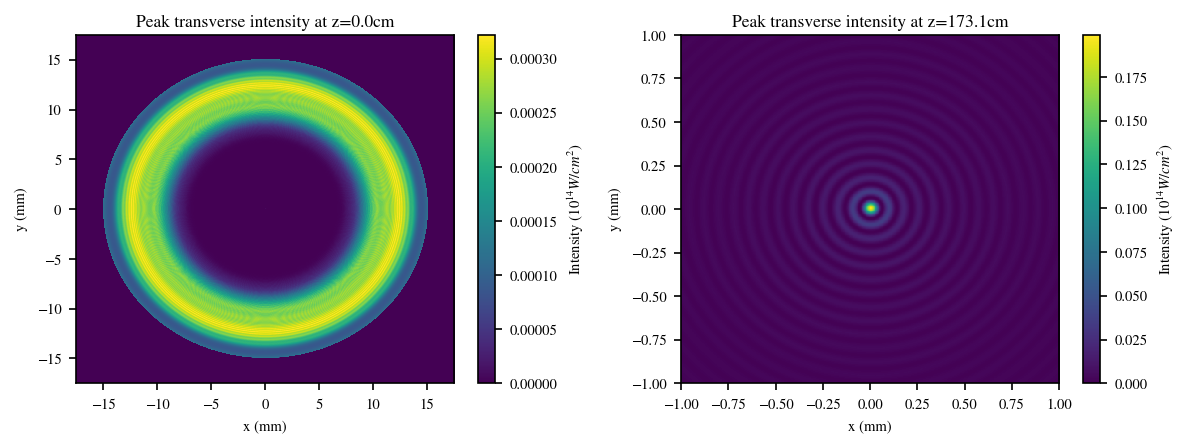

In [9]:
X = 35e3
Nx = 2**13
sel = r1 > 15e3 # Stop the outer rings from propagating
e1[sel] = 0.0
beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-10e4, X, Nx, path, lam, tau, 20, [-1, 1])

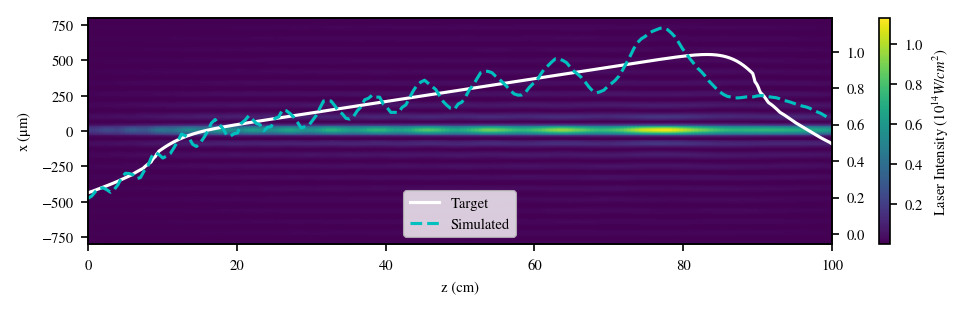

In [10]:
Nx = 2**11
Nz = 200
X = 12e3
Z = 100e4
I_0 = design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, z0-10e4, [-800, 800])

In [10]:
# First Optic A to Optic B
XA = lensA.X
NxA = lensA.Nx
beamParams = {'Nx' : NxA,
              'Ny' : NxA,
              'X' : XA,
              'Y' : XA,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 20,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
Nz0 = 400
z_ab = np.linspace(0, L, Nz0)
beam = laserbeam.Laser(beamParams)
e = beam.reconstruct_from_cyl(r0, E0, beam.x, beam.y)
beam.initialize_field(e)
I0 = ionization.intensity_from_field(E0)
print('Total input energy %0.2fmJ' % (beam.total_cyl_power(r0, I0)*tau))
interactions.beam_phase(beam, lensA)
beam.propagate(z_ab, 1.0)

Total input energy 7.32mJ


In [11]:
I_ab = np.zeros((Nz0, NxA))
for i in range(Nz0):
    I_ab[i, :] = beam.intensity_from_field(beam.load_field(i+1)[0])
I_ab = beam.prep_data(I_ab)

In [12]:
XB = 35e3
NxB = 2**13
pulseParams = {
    'Nt' : 2**6,
    'Nx' : NxB,
    'Ny' : NxB,
    'X' : XB,
    'Y' : XB,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
Z1 = z0
beam = laserbeam.Laser(pulseParams)
e = beam.reconstruct_from_cyl(r1, e1, beam.x, beam.y)
beam.initialize_field(e)
Nz1 = 400
z_bLO = np.linspace(0, Z1, Nz1)
beam.propagate(z_bLO, 1)

In [13]:
I_bLO = np.zeros((Nz1, NxB))
for i in range(Nz1):
    I_bLO[i, :] = beam.intensity_from_field(beam.load_field(i)[0])
I_bLO = beam.prep_data(I_bLO)

In [14]:
XP = 14e3
NxP = 2**11
NzP = 400
Z_p = 80e4
ne0 = 3.4e16/1e17
z = np.linspace(0, Z_p, 5000)
sim_start, n_plot, n = profile.lithium_oven_profile(z, 40e4, ne0)
#plt.style.use('presentation')
pulse2, I, ne = design.plasma_refraction(XP, NxP, Z_p, NzP, beam, pulseParams, ionization.Li, n, sim_start, 1,
                                        ne0, name='Plasma', ionization_type='lithium')

Initial pulse energy 7.17mJ
Final pulse energy 4.37mJ


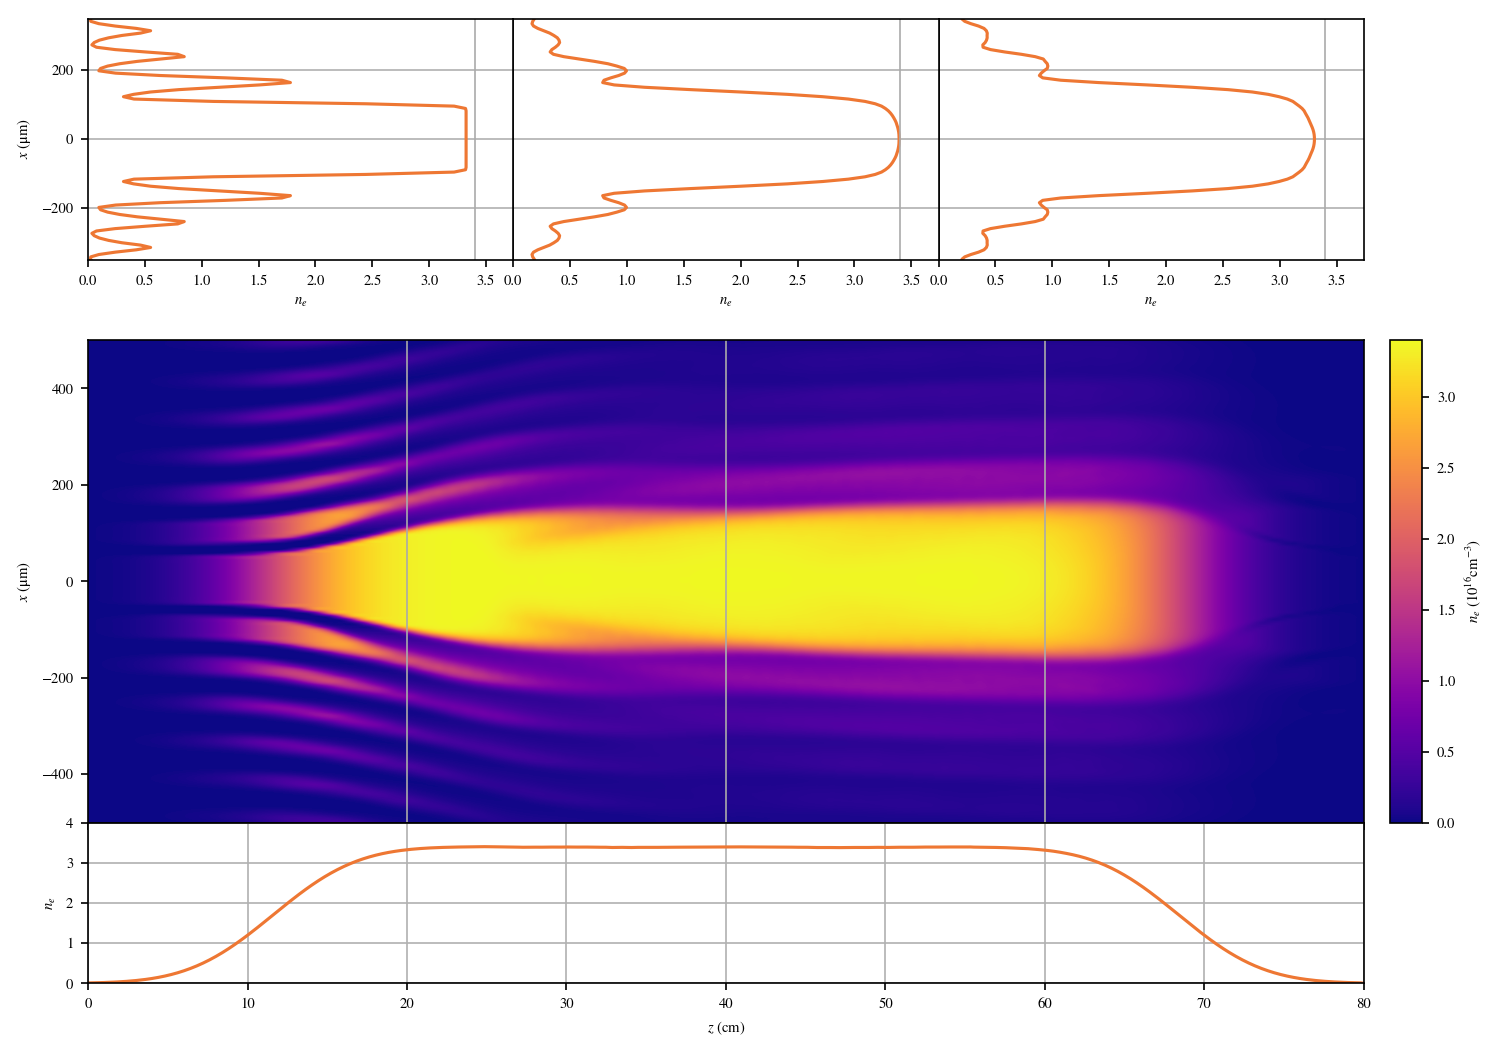

In [15]:
ext = [0, Z_p/1e4, -XP/2, XP/2]
design.plot_plasma_density(pulse2, ne, ne0, ext, lines=[20, 40, 60])

In [16]:
I_p = np.zeros((NzP, NxP))
for i in range(NzP):
    I_p[i, :] = np.amax(pulse2.intensity_from_field(pulse2.load_field(i)[0]), axis=0)
I_p = pulse2.prep_data(I_p)

In [17]:
NxD = 2**11
XD = 20e3
NzD = 400
ZD = 2e6
I_D = design.propagate_down_beampipe(pulse2, [0.8548e6, 1.2e6, ZD], [4e3, 5e3, 20e3], XD, NxD, NzD)

In [18]:
import numpy.ma as ma
from copy import copy
def prep_ma(Z, X, Nzi, Zi, Z0i, Xi, Nxi, array):
    
    # Calculate the size of the extended array
    Nx = int(Nxi*X/Xi)
    Nz = int(Nzi*Z/Zi)
    # Extend the array to fill the entire imshow with the correct spacing
    Im = np.zeros((Nx, Nz))
    Im = ma.asarray(Im)
    # Mark the entire array as invalid
    Im[:, :] = ma.masked
    # Fill in the intensity 
    Nx0 = int((Nx-Nxi)/2)
    Nz0 = int(Nzi*Z0i/Zi)
    Im[Nx0:Nx0+Nxi, Nz0:Nz0+Nzi] = array
    return Im

In [19]:
Z = L+Z1+Z_p+ZD
X = XA
ext0 = [0, Z/1e3, -X/2e3, X/2e3]
I0m = prep_ma(Z, X, Nz0, L, 0.0, XA, NxA, I_ab)
I1m = prep_ma(Z, X, Nz1, Z1, L, XB, NxB, I_bLO)
I2m = prep_ma(Z, X, NzP, Z_p, L+Z1, XP, NxP, I_p)
I3m = prep_ma(Z, X, NzD, ZD, L+Z1+Z_p, XD, NxD, I_D)

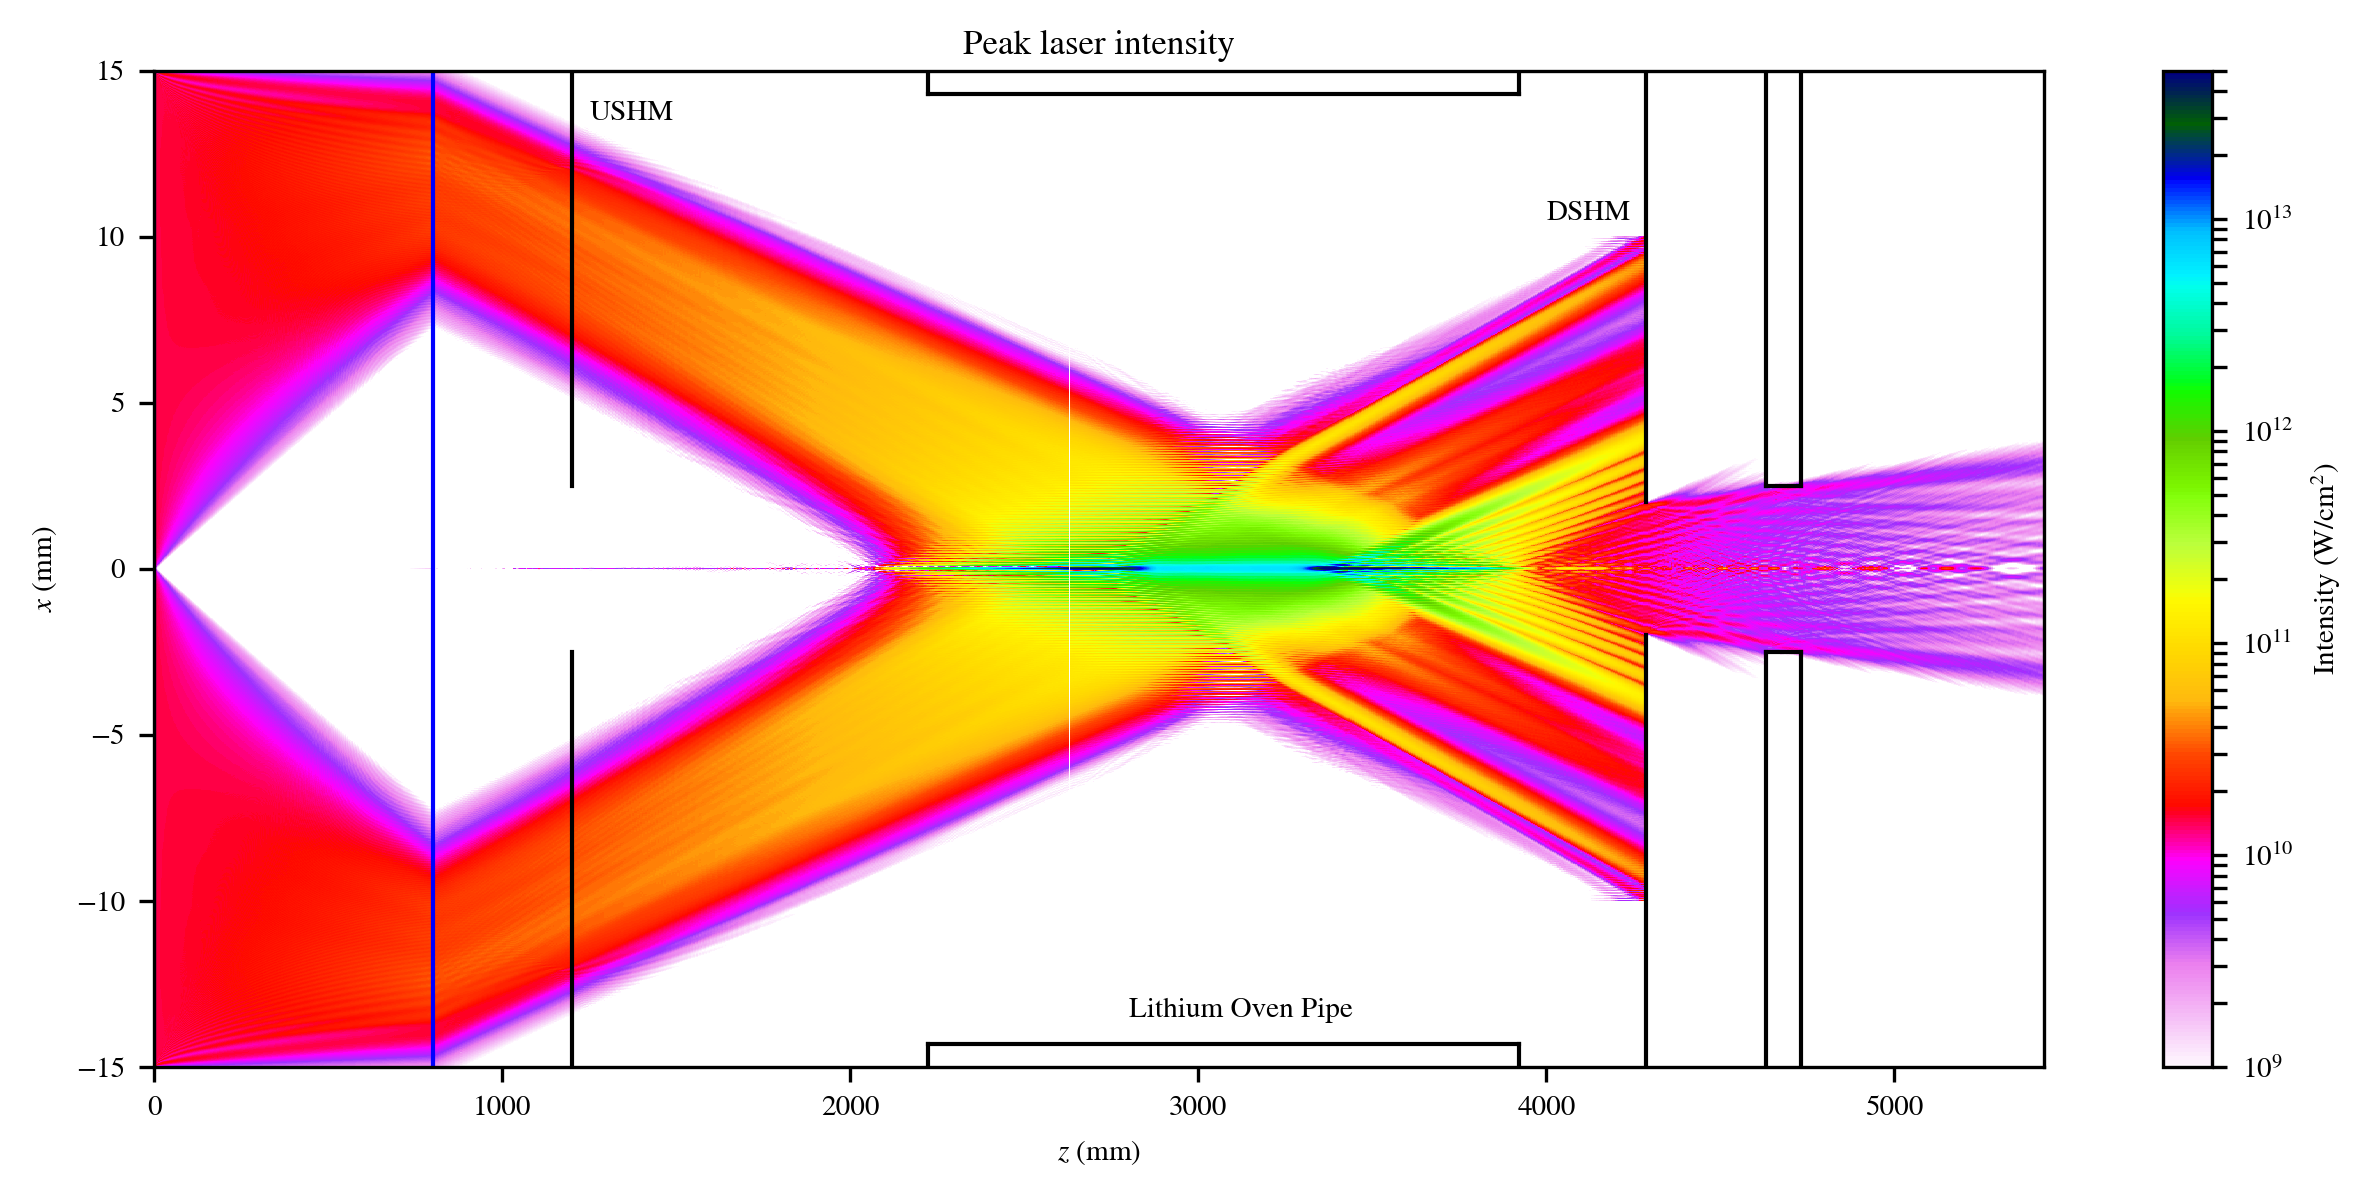

In [23]:
plt.figure(figsize=(8.5, 4), dpi=300)
palette = copy(plt.cm.gist_ncar_r)
palette.set_bad('w', 0.0)
palette.set_under('w', 1.0)
norm = colors.LogNorm(vmin=1e9, vmax=5e13)
im = plt.imshow(I_ab, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I0m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I1m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I2m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I3m*1e14, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.set_cmap(palette)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.ylim(-15, 15)

# Optic A and Optic B
plt.plot([0, 0], [-15, 15], 'b-', lw=1)
plt.plot([L/1e3, L/1e3], [-15, 15], 'b-', lw=1)
# USHM
dz = 401
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 2.5], 'k-', lw=1)
plt.text(1250, 13.5, 'USHM')
# LO pipe
dz = 1424.6
l = 1695.5
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-14.3, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [14.3, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [25.4, 14.3], 'k-', lw=1)
plt.text(2800, -13.5, 'Lithium Oven Pipe')
# DSHM
p_end = L/1e3+z0/1e3+800
dz = p_end+854.8
plt.plot([dz, dz], [-25.4, -2], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2], 'k-', lw=1)
plt.text(4000, 10.5, 'DSHM')
# Plasma
#plt.plot([p_end-800, p_end], [-10, -10], 'k-', lw=1)
# Differential Pumping
dz = p_end+1200
l = 100
plt.plot([dz, dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [-2.5, -2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [2.5, 2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [25.4, 2.5], 'k-', lw=1)

#plt.plot([p_end-400])
plt.tight_layout()
plt.show()

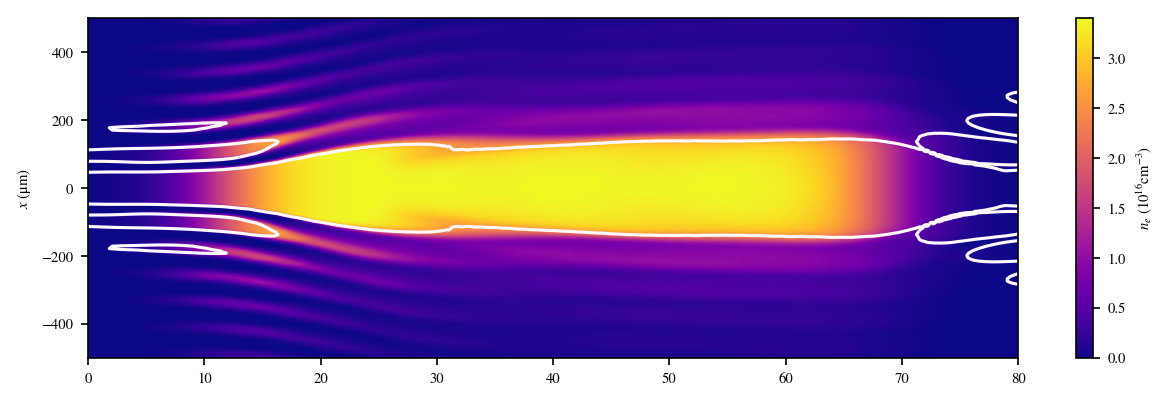

In [24]:
fig = plt.figure(figsize=(10, 3), dpi=150)
ne_im = np.flipud(np.transpose(ne/1e16))
ext = [0, Z_p/1e4, -XP/2, XP/2]
im = plt.imshow(ne_im, aspect='auto', extent=ext, cmap='plasma',
                interpolation='Spline16')
plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylim(-500, 500)
cb = plt.colorbar(im)
cb.set_label(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')

dx = pulse2.x[1]-pulse2.x[0]
plt.contour(np.array(pulse2.z)/1e4, pulse2.x+dx, I_p, [0.04] )
#plt.colorbar()
plt.show()

In [ ]:
# First Optic A to Optic B
XA = lensA.X
NxA = lensA.Nx
beamParams = {'Nx' : NxA,
              'Ny' : NxA,
              'X' : XA,
              'Y' : XA,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 20,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
Nz0 = 400
z_ab = np.linspace(0, L, Nz0)
beam = laserbeam.Laser(beamParams)
e = beam.reconstruct_from_cyl(r0, E0, beam.x, beam.y)
beam.initialize_field(e)
I0 = ionization.intensity_from_field(E0)
print('Total input energy %0.2fmJ' % (beam.total_cyl_power(r0, I0)*tau))
interactions.beam_phase(beam, lensA)
beam.propagate(z_ab, 1.0)

I_ab = np.zeros((Nz0, NxA))
for i in range(Nz0):
    I_ab[i, :] = beam.intensity_from_field(beam.load_field(i+1)[0])
I_ab = beam.prep_data(I_ab)

XB = 30e3
NxB = 2**13
pulseParams = {
    'Nt' : 2**6,
    'Nx' : NxB,
    'Ny' : NxB,
    'X' : XB,
    'Y' : XB,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
Z1 = z0
beam = laserbeam.Laser(pulseParams)
e = beam.reconstruct_from_cyl(r1, e1, beam.x, beam.y)
beam.initialize_field(e)
Nz1 = 400
z_bLO = np.linspace(0, Z1, Nz1)
beam.propagate(z_bLO, 1)

I_bLO = np.zeros((Nz1, NxB))
for i in range(Nz1):
    I_bLO[i, :] = beam.intensity_from_field(beam.load_field(i)[0])
I_bLO = beam.prep_data(I_bLO)

XP = 14e3
NxP = 2**11
NzP = 400
Z_p = 80e4
ne0 = 0.0
z = np.linspace(0, Z_p, 5000)
sim_start, n_plot, n = profile.lithium_oven_profile(z, 40e4, ne0)
#plt.style.use('presentation')
pulseParams['Nt'] = 2
pulse2, I, ne = design.plasma_refraction(XP, NxP, Z_p, NzP, beam, pulseParams, ionization.Li, n, sim_start, 1,
                                        ne0, name='Plasma')

ext = [0, Z_p/1e4, -XP/2, XP/2]

I_p = np.zeros((NzP, NxP))
for i in range(NzP):
    I_p[i, :] = np.amax(pulse2.intensity_from_field(pulse2.load_field(i)[0]), axis=0)
I_p = pulse2.prep_data(I_p)

NxD = 2**11
XD = 20e3
NzD = 400
ZD = 2e6
I_D = design.propagate_down_beampipe(pulse2, [0.8548e6, 1.2e6, ZD], [4e3, 5e3, 20e3], XD, NxD, NzD)

import numpy.ma as ma
from copy import copy
def prep_ma(Z, X, Nzi, Zi, Z0i, Xi, Nxi, array):
    
    # Calculate the size of the extended array
    Nx = int(Nxi*X/Xi)
    Nz = int(Nzi*Z/Zi)
    # Extend the array to fill the entire imshow with the correct spacing
    Im = np.zeros((Nx, Nz))
    Im = ma.asarray(Im)
    # Mark the entire array as invalid
    Im[:, :] = ma.masked
    # Fill in the intensity 
    Nx0 = int((Nx-Nxi)/2)
    Nz0 = int(Nzi*Z0i/Zi)
    Im[Nx0:Nx0+Nxi, Nz0:Nz0+Nzi] = array
    return Im

Z = L+Z1+Z_p+ZD
X = XA
ext0 = [0, Z/1e3, -X/2e3, X/2e3]
I0m = prep_ma(Z, X, Nz0, L, 0.0, XA, NxA, I_ab)
I1m = prep_ma(Z, X, Nz1, Z1, L, XB, NxB, I_bLO)
I2m = prep_ma(Z, X, NzP, Z_p, L+Z1, XP, NxP, I_p)
I3m = prep_ma(Z, X, NzD, ZD, L+Z1+Z_p, XD, NxD, I_D)

Total input energy 7.32mJ


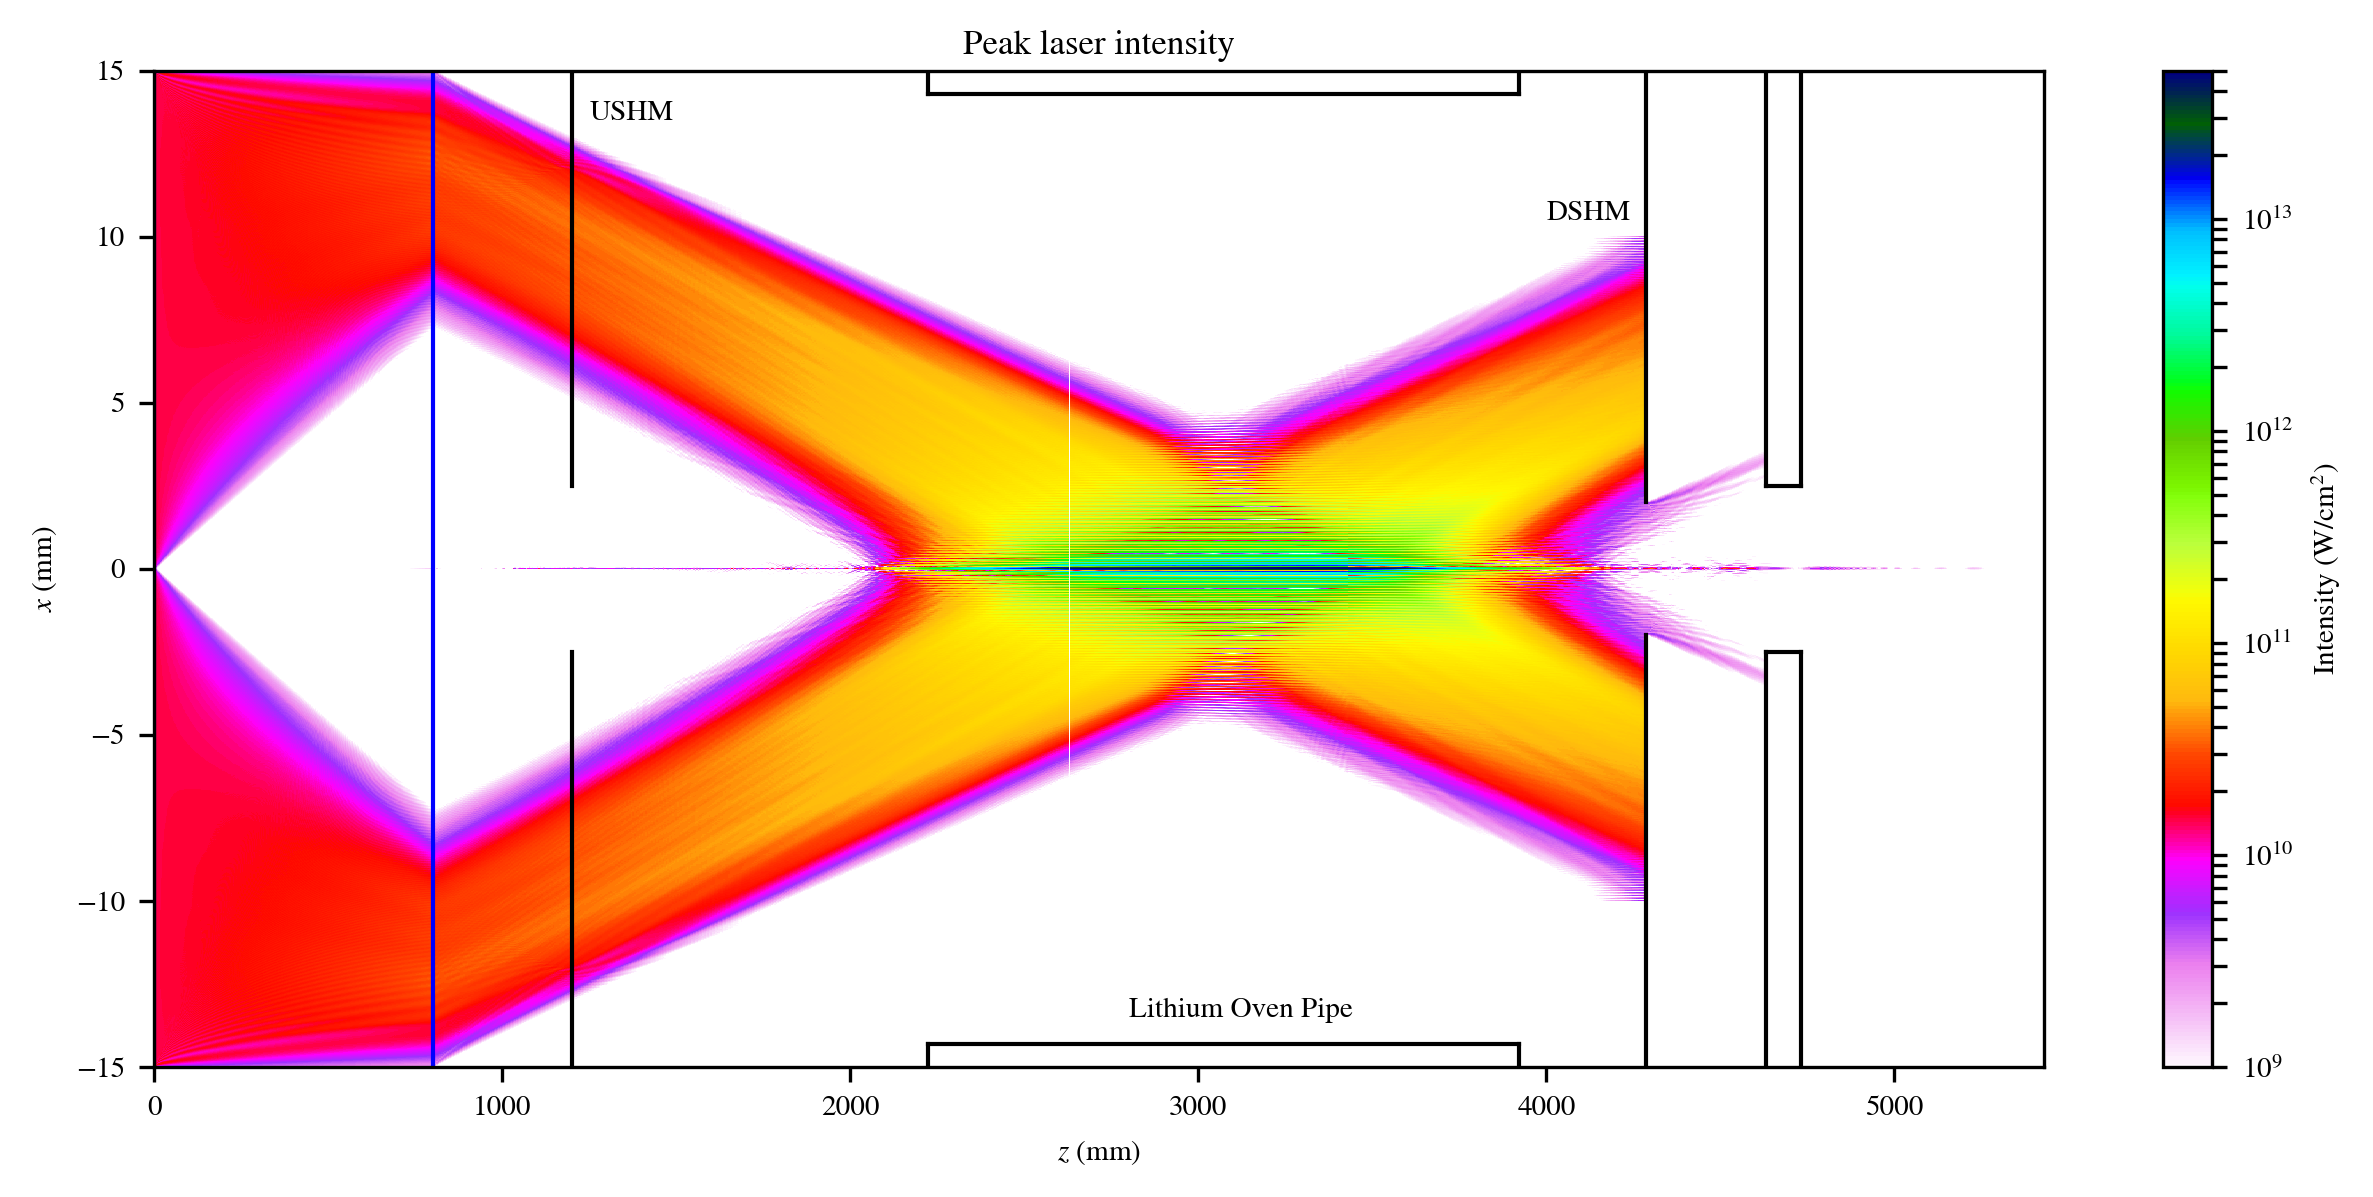

In [27]:
plt.figure(figsize=(8.5, 4), dpi=300)
palette = copy(plt.cm.gist_ncar_r)
palette.set_bad('w', 0.0)
palette.set_under('w', 1.0)
norm = colors.LogNorm(vmin=1e9, vmax=5e13)
im = plt.imshow(I_ab, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I0m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I1m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I2m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I3m*1e14, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.set_cmap(palette)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.ylim(-15, 15)

# Optic A and Optic B
plt.plot([0, 0], [-15, 15], 'b-', lw=1)
plt.plot([L/1e3, L/1e3], [-15, 15], 'b-', lw=1)
# USHM
dz = 401
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 2.5], 'k-', lw=1)
plt.text(1250, 13.5, 'USHM')
# LO pipe
dz = 1424.6
l = 1695.5
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-14.3, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [14.3, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [25.4, 14.3], 'k-', lw=1)
plt.text(2800, -13.5, 'Lithium Oven Pipe')
# DSHM
p_end = L/1e3+z0/1e3+800
dz = p_end+854.8
plt.plot([dz, dz], [-25.4, -2], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2], 'k-', lw=1)
plt.text(4000, 10.5, 'DSHM')
# Plasma
#plt.plot([p_end-800, p_end], [-10, -10], 'k-', lw=1)
# Differential Pumping
dz = p_end+1200
l = 100
plt.plot([dz, dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [-2.5, -2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [2.5, 2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [25.4, 2.5], 'k-', lw=1)

#plt.plot([p_end-400])
plt.tight_layout()
plt.show()